# TS5: Estimación espectral: Ancho de banda de señales reales
### Autoras: Noelia Ferrari y Angelina Fantauzzo Fabio

**Consigna**: 
En el repositorio PDStestbench encontrará tres tipos de señales registradas:

Electrocardiograma (ECG). En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas más abajo.
Pletismografía (PPG). El archivo PPG.csv contiene una señal registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.
Audio. Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.
Los detalles de cómo acceder a dichos registros los pueden encontrar en lectura_sigs.py

Se pide:

1) Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

2) Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.

Bonus:

💎 Proponga algún tipo de señal que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.


## Introducciones teóricas

### Densidad espectral 

En el análisis de señales, es muy importante conocer cómo se distribuye la energía de una señal a lo largo del dominio de la frecuencia. Esta información nos permite identificar componentes dominantes, ruido, interferencias y características propias de cada tipo de señal (por ejemplo, ECG, PPG o audio).
La herramienta principal para esto es la densidad espectral de potencia (PSD, Power Spectral Density). La PSD describe cómo se reparte la potencia de la señal en función de la frecuencia, y se define como:
$$P_x(f) = \lim_{T \to \infty} \frac{1}{T} \left| X_T(f) \right|^2$$
donde Xt(f) es la Transformada de Fourier de la señal truncada a un intervalo de duración T. 

Existen diferentes metodos para estimas este valor 

**Periodograma**
$$\hat{P}_{xx}(f) = \frac{1}{N} \left| \sum_{n=0}^{N-1} x[n] e^{-j 2 \pi f n / N} \right|^2$$


**Periodograma ventaneado**
$$\hat{P}_{xx}^{(w)}(f) = \frac{1}{\sum_{n=0}^{N-1} w^2[n]} \left| \sum_{n=0}^{N-1} x[n] w[n] e^{-j 2 \pi f n / N} \right|^2$$

Para mejorar el desparramiento espectral ventaneamos y luego transformamos.

**Método de Welch**
$$\hat{P}_{xx}^{\text{Welch}}(f) = \frac{1}{K} \sum_{k=1}^{K} \hat{P}_{xx,k}^{(w)}(f)$$

Divide la señal en segmentos solapados, aplica una ventana a cada segmento, calcula el periodograma de cada uno y luego promedia

**Blackman–Tukey**
$$\hat{P}_{xx}^{BT}(f) = \sum_{m=-M}^{M} w[m] r_{xx}[m] e^{-j 2 \pi f m / N}$$

Se basa en mejorar la secuencia de autocorrelación rxx[m] de la señal y una ventana de suavizado w[m]


Cada uno de estos metodos buscan mejorar la varianza y la resolucion espectral. Al analizarlos se llega a la conclusion de que existe una relacion de compromiso entre estos dos, si se mejora uno empeora el otro.

### Ancho de banda

El ancho de banda de una señal es el rango de frecuencias donde la señal concentra la mayor parte de su energía.

# Desarollo del codigo 

In [ ]:
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io.wavfile import write

In [ ]:
def blackman_tukey(x, M=None):
    """Estimador de PSD por el método de Blackman–Tukey."""
    N = len(x)
    if M is None:
        M = N // 5
    r_len = 2 * M - 1
    r = np.correlate(x[:r_len], x[:r_len], mode='same') / r_len
    Px = np.abs(np.fft.fft(r * sig.windows.blackman(r_len), n=N))
    return Px

## Punto 1

### Primer señal: ECG con ruido

In [ ]:
mat_struct = sio.loadmat('ECG_TP4.mat')
ecg = mat_struct['ecg_lead'].squeeze()   # <-- convierte (N,1) en (N,)
ecg = ecg - np.mean(ecg)
N = len(ecg)
fs_ecg = 1000 # Hz

In [ ]:
# Periodograma de ECG
f_per, P_per = sig.periodogram(ecg, fs=fs_ecg)

#welch 
f_welch, P_welch = sig.welch(ecg, fs=fs_ecg)

#periodograma ventaneado con hann
window = sig.windows.hann(N)
f_win, P_win = sig.periodogram(ecg, fs=fs_ecg, window=window, scaling='density')

#blackman tuckey 
P_bt = blackman_tukey(ecg)
f_bt = np.linspace(-fs_ecg/2, fs_ecg/2, len(P_bt))

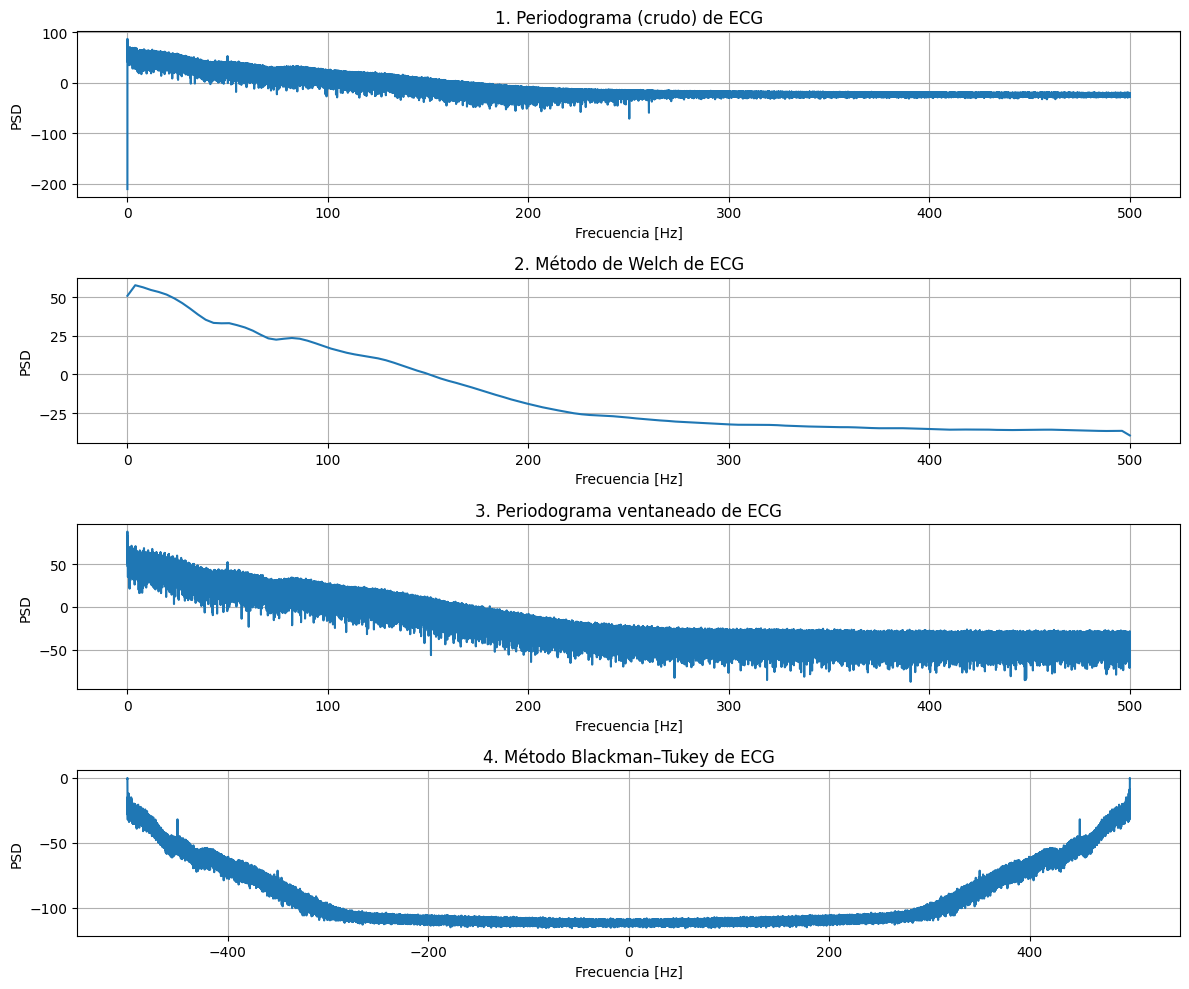

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(f_per, 10*np.log10(P_per))
plt.title('1. Periodograma (crudo) de ECG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(f_welch, 10*np.log10(P_welch))
plt.title('2. Método de Welch de ECG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(f_win, 10*np.log10(P_win))
plt.title('3. Periodograma ventaneado de ECG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(f_bt, 10*np.log10(P_bt / np.max(P_bt)))
plt.title('4. Método Blackman–Tukey de ECG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.tight_layout()
plt.show()

### Segunda señal: PPG con ruido

In [ ]:
fs_ppg = 400 # Hz
ppg = np.genfromtxt('PPG.csv', delimiter=',', skip_header=1)  # Omitir la cabecera si existe
N_ppg = len(ppg)

In [ ]:
# Periodograma de ECG
f2_per, P2_per = sig.periodogram(ppg, fs=fs_ppg)

#welch 
f2_welch, P2_welch = sig.welch(ppg, fs=fs_ppg)

#periodograma ventaneada
window = sig.windows.hann(N_ppg)
f2_win, P2_win = sig.periodogram(ppg, fs=fs_ppg,  window=window, scaling='density')

#blackman tuckey
P_bt_2 = blackman_tukey(ppg)
f_bt_2 = np.linspace(-fs_ppg/2, fs_ppg/2, len(P_bt_2))

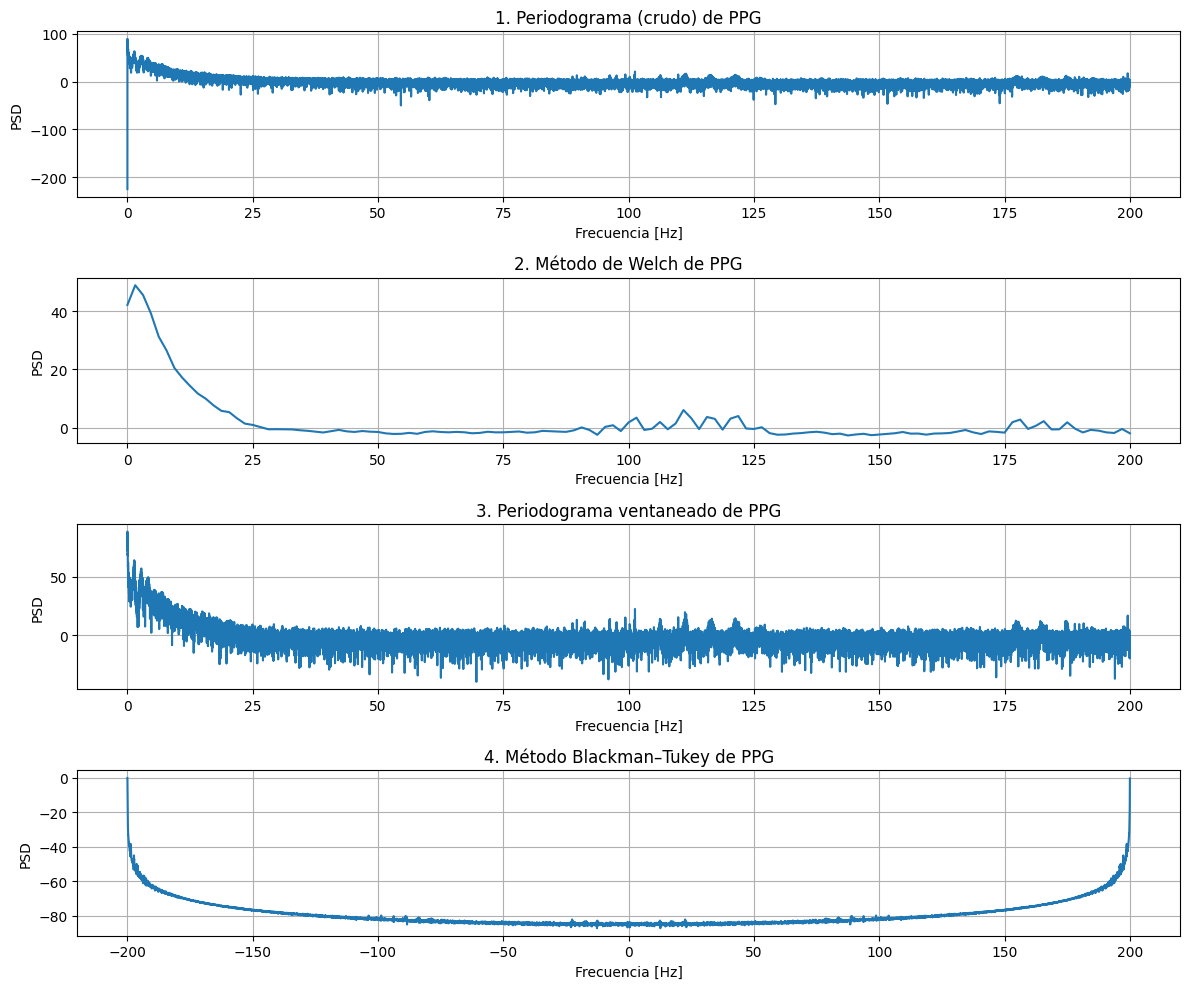

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(f2_per, 10*np.log10(P2_per))
plt.title('1. Periodograma (crudo) de PPG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(f2_welch, 10*np.log10(P2_welch))
plt.title('2. Método de Welch de PPG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(f2_win, 10*np.log10(P2_win))
plt.title('3. Periodograma ventaneado de PPG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(f_bt_2, 10*np.log10(P_bt_2 / np.max(P_bt_2)))
plt.title('4. Método Blackman–Tukey de PPG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.grid(True)

plt.tight_layout()
plt.show()

### Tercer señal: audio "la cucaracha"

In [ ]:
fs_audio, audio = sio.wavfile.read('la cucaracha.wav')
audio = audio.astype(float)
audio = audio - np.mean(audio)
N_audio = len(audio)

In [ ]:
#periodograma crudo
f_raw, P_raw = sig.periodogram(audio, fs=fs_audio, scaling='density')

#periodograma ventaneado (Hann)
window = sig.windows.hann(N_audio)
f_win, P_win = sig.periodogram(audio, fs=fs_audio, window=window, scaling='density')

#welch (promediado)
f_welch, P_welch = sig.welch(audio, fs=fs_audio, window='hann', nperseg=2048, noverlap=1024)

#blackman–Tukey
P_bt = blackman_tukey(audio)
f_bt = np.linspace(-fs_audio / 2, fs_audio / 2, len(P_bt))

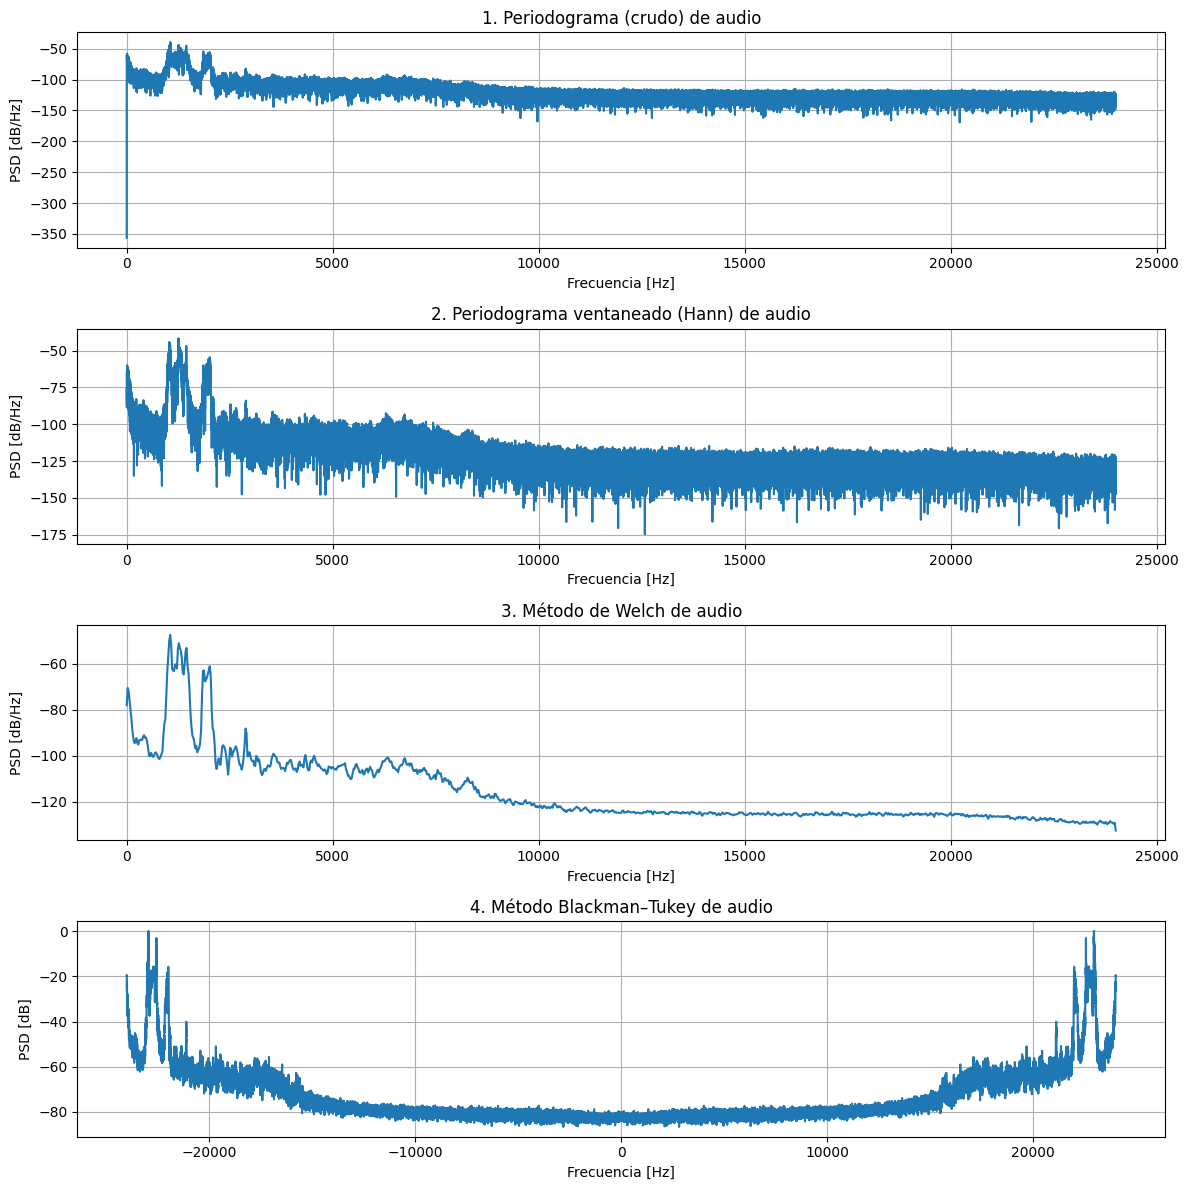

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plt.plot(f_raw, 10 * np.log10(P_raw))
plt.title('1. Periodograma (crudo) de audio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(f_win, 10 * np.log10(P_win))
plt.title('2. Periodograma ventaneado (Hann) de audio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(f_welch, 10 * np.log10(P_welch))
plt.title('3. Método de Welch de audio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(f_bt, 10 * np.log10(P_bt / np.max(P_bt)))
plt.title('4. Método Blackman–Tukey de audio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.grid(True)

plt.tight_layout()
plt.show()

### Analisis de los resultados del punto 1

En los gráficos observamos diferencias y eso se debe a que cada método analiza la densidad espectral de maneras diferentes. Existe una relación de compromiso importante en estos métodos entre la resolución en frecuencia y la varianza del estimador: cuando se mejora una, generalmente se perjudica la otra. El periodograma ofrece alta resolución porque utiliza toda la señal, pero su varianza es grande, lo que hace que el espectro se vea más “ruidoso”. El método de Welch, al promediar varios periodogramas de tramos solapados, reduce mucho la varianza y genera un espectro más estable, aunque con menor resolución por el uso de segmentos más cortos. El periodograma ventaneado atenúa las fugas espectrales y suaviza el espectro, pero también sacrifica algo de resolucion. En el caso del Blackman–Tukey, la resolución y la varianza dependen del largo de la ventana de autocorrelación, una ventana más larga mejora la resolución pero aumenta el ruido, mientras que una más corta suaviza el resultado. En señales biológicas, donde se busca identificar las frecuencias dominantes sin que el ruido o las variaciones pequeñas las oculten, conviene usar Welch o Blackman–Tukey. En cambio, en señales de audio, que tienen un contenido más amplio y continuo en frecuencia, los métodos directos como el periodograma o el ventaneado resultan más adecuados para mantener la resolución y el detalle espectral.

## Punto 2

Desarollamos una funcion para calcular el ancho de banda, como paramentros se le pasa la potencia, frecuencia y la cota. La cota dependera de que tipo de señal estemos analizando, es un porcentaje de energía acumulada. Para las primeras dos señales elegimos una cota del 95% ya que la mayor parte de la información útil está concentrada en bajas frecuencias y el resto es ruido o variaciones pequeñas que no conviene contar como parte del ancho de banda. En cambio en los audios usamos una cota mayor, del 99%, ya que el contenido de energía está mucho más distribuido y queremos incluir casi todo el rango audible.

In [ ]:
def estimar_BW(PSD, ff, cota):
    df = ff[1] - ff[0]
    energia_acumulada = np.cumsum(PSD * df)
    energia_total = energia_acumulada[-1]
    energia_corte = energia_total * cota
    idx_corte = np.where(energia_acumulada >= energia_corte)[0][0]
    frec_BW = ff[idx_corte]
    return frec_BW

In [ ]:
BW_ecg_per = estimar_BW(P_per, f_per, 0.95)
BW_ecg_welch = estimar_BW(P_welch, f_welch, 0.95)
BW_ecg_win = estimar_BW(P_win, f_win, 0.95)

# En Blackman–Tukey el espectro está centrado en 0, por lo tanto
# usamos solo la mitad positiva para medir hasta fs/2
mask_bt_ecg = f_bt >= 0
BW_ecg_bt = estimar_BW(P_bt[mask_bt_ecg], f_bt[mask_bt_ecg], 0.95)

print("=== Ancho de banda ECG ===")
print(f"Periodograma:        {BW_ecg_per:.2f} Hz")
print(f"Welch:               {BW_ecg_welch:.2f} Hz")
print(f"Ventaneado:   {BW_ecg_win:.2f} Hz")
print(f"Blackman–Tukey:      {BW_ecg_bt:.2f} Hz\n")


# --- PPG ---
BW_ppg_per = estimar_BW(P2_per, f2_per, 0.95)
BW_ppg_welch = estimar_BW(P2_welch, f2_welch, 0.95)
BW_ppg_win = estimar_BW(P2_win, f2_win, 0.95)

mask_bt_ppg = f_bt_2 >= 0
BW_ppg_bt = estimar_BW(P_bt_2[mask_bt_ppg], f_bt_2[mask_bt_ppg], 0.95)

print("=== Ancho de banda PPG ===")
print(f"Periodograma:        {BW_ppg_per:.2f} Hz")
print(f"Welch:               {BW_ppg_welch:.2f} Hz")
print(f"Ventaneado:   {BW_ppg_win:.2f} Hz")
print(f"Blackman–Tukey:      {BW_ppg_bt:.2f} Hz\n")


# --- AUDIO ---
BW_audio_per = estimar_BW(P_raw, f_raw, 0.99)
BW_audio_welch = estimar_BW(P_welch, f_welch, 0.99)
BW_audio_win = estimar_BW(P_win, f_win, 0.99)

mask_bt_audio = f_bt >= 0
BW_audio_bt = estimar_BW(P_bt[mask_bt_audio], f_bt[mask_bt_audio], 0.99)

print("=== Ancho de banda AUDIO ===")
print(f"Periodograma:        {BW_audio_per:.2f} Hz")
print(f"Welch:               {BW_audio_welch:.2f} Hz")
print(f"Ventaneado:   {BW_audio_win:.2f} Hz")
print(f"Blackman–Tukey:      {BW_audio_bt:.2f} Hz\n")

=== Ancho de banda ECG ===
Periodograma:        17.34 Hz
Welch:               1500.00 Hz
Ventaneado (Hann):   1861.67 Hz
Blackman–Tukey:      22969.66 Hz

=== Ancho de banda PPG ===
Periodograma:        0.10 Hz
Welch:               4.69 Hz
Ventaneado (Hann):   0.05 Hz
Blackman–Tukey:      200.00 Hz

=== Ancho de banda AUDIO ===
Periodograma:        2014.67 Hz
Welch:               2015.62 Hz
Ventaneado (Hann):   2019.33 Hz
Blackman–Tukey:      23007.99 Hz



### Analisis de los resultados del punto 2

Al estimar el ancho de banda con distintos métodos (Periodograma, Welch, Hann y Blackman–Tukey) se observaron diferencias grandes, sobre todo en las señales biológicas como el ECG y el PPG. Esto ocurre porque cada método calcula la densidad espectral de potencia de una forma distinta: algunos, como Welch o el ventaneado, suavizan el espectro y pueden ensancharlo, mientras que otros, como el periodograma, son más ruidosos pero reflejan mejor las frecuencias reales. En señales de baja frecuencia, los métodos promediados o con ventanas cortas pueden mostrar energía falsa en frecuencias altas, dando anchos de banda mayores. En cambio, en señales de audio, todos los métodos coinciden más porque la energía está distribuida en un rango amplio. En resumen, las diferencias no significan que haya un error, sino que dependen de cómo cada método trata la señal y de los parámetros elegidos

# Bonus

La señal la obtuve acá: https://physionet.org/content/wearable-exam-stress/1.0.0/data/S1/Final/#files-panel es el participante S1.

**Señal propuesta**: Acelerómetro (ACC)
Se utilizó la señal ACC.csv del **Exam Stress Dataset** de **PhysioNet**, la cual proviene del sensor **Empatica E4**. 
Este sensor cuenta con un acelerómetro que mide la aceleración del cuerpo en los ejes x,y,z en unidades de gravedad terrestre (g).
Según la descripción oficial del dispositivo, la frecuencia de muestreo es de 32Hz.

Para este análisis, se tomó una de las componentes (el eje x), y se aplicó el mismo procedimiento que con las señales ECG y PPG.

In [ ]:
import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write

# Lectura de señal de acelerómetro (ACC)

fs_acc = 32  # frecuencia de muestreo en Hz 
acc = np.genfromtxt('ACC.csv', delimiter=',', skip_header=1)
acc = acc[:, 0]   # usa la primera columna (X)
acc = acc - np.mean(acc)
N_acc = len(acc)


# --- Periodograma ---
f_acc_per, P_acc_per = sig.periodogram(acc, fs=fs_acc)

# --- Welch ---
f_acc_welch, P_acc_welch = sig.welch(acc, fs=fs_acc)

# --- Periodograma ventaneado (Hann) ---
window = sig.windows.hann(N_acc)
f_acc_win, P_acc_win = sig.periodogram(acc, fs=fs_acc, window=window, scaling='density')

# --- Blackman–Tukey ---
M_acc = 100
rxx_acc = sig.correlate(acc, acc, mode='full') / N_acc
mid_acc = len(rxx_acc)//2
rxx_acc = rxx_acc[mid_acc - M_acc : mid_acc + M_acc + 1]
w_bt_acc = sig.windows.blackman(len(rxx_acc))
rxx_acc_win = rxx_acc * w_bt_acc

P_bt_acc = np.abs(np.fft.fftshift(np.fft.fft(rxx_acc_win, 2048)))
f_bt_acc = np.linspace(-fs_acc/2, fs_acc/2, len(P_bt_acc))

# --- Gráficos ---
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(f_acc_per, 10*np.log10(P_acc_per))
plt.title('1. Periodograma (crudo) de ACC')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(f_acc_welch, 10*np.log10(P_acc_welch))
plt.title('2. Método de Welch de ACC')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(f_acc_win, 10*np.log10(P_acc_win))
plt.title('3. Periodograma ventaneado (Hann) de ACC')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(f_bt_acc, 10*np.log10(P_bt_acc / np.max(P_bt_acc)))
plt.title('4. Método Blackman–Tukey de ACC')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#ANCHO DE BANDA
# --- ACC ---
BW_acc_per = estimar_BW(P_acc_per, f_acc_per, 0.95)
BW_acc_welch = estimar_BW(P_acc_welch, f_acc_welch, 0.95)
BW_acc_win = estimar_BW(P_acc_win, f_acc_win, 0.95)

mask_bt_acc = f_bt_acc >= 0
BW_acc_bt = estimar_BW(P_bt_acc[mask_bt_acc], f_bt_acc[mask_bt_acc], 0.95)

print("=== Ancho de banda ACC ===")
print(f"Periodograma:        {BW_acc_per:.2f} Hz")
print(f"Welch:               {BW_acc_welch:.2f} Hz")
print(f"Ventaneado (Hann):   {BW_acc_win:.2f} Hz")
print(f"Blackman–Tukey:      {BW_acc_bt:.2f} Hz\n")


Los gráficos de PSD (especialmente los métodos de Welch y Blackman-Tukey, que son los más consistentes) confirman que la mayor parte de la potencia se ubica cerca de 0 Hz.
Esta concentración de energía en frecuencias muy bajas es propia del movimiento humano lento, como los cambios de postura, movimientos de la mano al escribir, o el temblor involuntario de baja frecuencia asociado al estrés.
 

# Conclusión

El análisis de las señales ECG, PPG y audio mostró que los distintos métodos de PSD (Periodograma, Welch y Blackman-Tukey) producen resultados distintos según la señal y sus propiedades.
El **periodograma** ofrece alta resolución pero es ruidoso, **Welch** reduce la varianza al promediar segmentos solapados,  **Blackman-Tukey** depende del tamaño de la ventana de autocorrelación, ajustando resolución y la suavidad.

Al estimar el **ancho de banda**, las señales biológicas mostraron mayores diferencias entre métodos debido a cómo suavizan o ensanchan el espectro, mientras que la señal de audio fue consistente.

El análisis del **acelerómetro (ACC)** confirmó que la mayor parte de la energía se concentra cerca de 0 Hz, reflejando movimientos humanos lentos. 
